# Plotting validation periods

---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, Interval,
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForPositiveMeasure,
    SocialDistancingForPositiveMeasureHousehold)

from lib.inference import gen_initial_seeds, downsample_cases
from lib.plot import Plotter

from lib.experiment import run_experiment, save_summary, load_summary, get_calibrated_params

from lib.calibration_settings import (
    command_line_area_codes, 
    settings_lockdown_dates,
    settings_model_param_bounds,
    calibration_setting_paths,
    calibration_setting_paths_full,
    calibration_states)
import matplotlib.pyplot as plt

In [3]:
calibration_period_only = True
full_scale = False
p_stay_home = 1.0 # TBD
dry_run = False
plot = True

#
######
#
random_repeats = 50 
c = 0
np.random.seed(c)
num_workers = multiprocessing.cpu_count()
TO_HOURS = 24.0

In [4]:
def standard_testing(max_time, cases):
    daily_increase = cases.sum(axis=1)[1:] - cases.sum(axis=1)[:-1]
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 1 * TO_HOURS,     # in hours
        'test_reporting_lag'  : 2 * TO_HOURS,     # in hours (actual and self-report delay)
        'tests_per_batch'     : int(daily_increase.max()), # test capacity based on empirical positive tests
        'test_fpr'            : 0.0, # test false positive rate
        'test_fnr'            : 0.0, # test false negative rate
        'test_smart_delta'    : 3 * TO_HOURS, # in hours
        'test_smart_duration' : 7 * TO_HOURS, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

def params_to_strg(d):
    l = [
        f"{d['betas']['education']:8.4f}",
        f"{d['betas']['social']:8.4f}",
        f"{d['betas']['bus_stop']:8.4f}",
        f"{d['betas']['office']:8.4f}",
        f"{d['betas']['supermarket']:8.4f}",
        f"{d['beta_household']:8.4f}",
    ]
    return ','.join(l)

headerstr = ' educat | social | bus_st | office | superm | househ '

#### Simulate for each town

In [5]:
if full_scale:
    setting_paths = calibration_setting_paths_full
else:
    setting_paths = calibration_setting_paths

In [6]:
for country in ['GER', 'CH']:
    for area in setting_paths[country].keys():
        
        # start simulation when calibration started       
        mob_settings = setting_paths[country][area][0]
        start_date_calibration = setting_paths[country][area][1]
        end_date_calibration = setting_paths[country][area][2]

        # lockdown dates
        start_date_lockdown = settings_lockdown_dates[country]['start']
        end_date_lockdown = settings_lockdown_dates[country]['end']      

        # set time frame
        if calibration_period_only:
            start_date = start_date_calibration
            end_date = end_date_calibration
        else:
            start_date = start_date_calibration
            end_date = end_date_lockdown

        sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        max_time = TO_HOURS * sim_days # in hours

        # load mobility file
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)

        # case data + scaling
        unscaled_area_cases = collect_data_from_df(country=country, area=area, datatype='new',
            start_date_string=start_date, end_date_string=end_date)
        
        sim_cases, unscaled_sim_cases = downsample_cases(unscaled_area_cases, mob)
        
        # distributions
        distributions = CovidDistributions(country=country)

        # seeds
        initial_seeds = gen_initial_seeds(
            unscaled_sim_cases, 
            downsampling=mob.downsample,
            day=0)

        # calibrated parameters
        calibrated_params = get_calibrated_params(country, area)

        print(country, area, f'{mob.downsample}x', ' Days: ', sim_days,'  Start: ', start_date, '  End: ', end_date, )
        print('Start cases: Scaled : ', sim_cases[0].sum(), sim_cases[0], 'Unscaled : ' , unscaled_sim_cases[0].sum(), unscaled_sim_cases[0])
        print('End cases:   Scaled : ',  sim_cases[-1].sum(), sim_cases[-1], 'Unscaled : ' , unscaled_sim_cases[-1].sum(), unscaled_sim_cases[-1])
        print('Scaled seeds:  ', initial_seeds)
        print('Unscaled seeds:',  gen_initial_seeds(
            unscaled_sim_cases, 
            downsampling=1,
            day=0))
        
        # print(headerstr)
        # print(params_to_strg(calibrated_params))

        # run
        measure_list =  [
            SocialDistancingForPositiveMeasure(
                t_window=Interval(0.0, max_time), p_stay_home=1.0),

            SocialDistancingForPositiveMeasureHousehold(
                t_window=Interval(0.0, max_time), p_isolate=1.0)
        ]

        if not calibration_period_only:
            days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
            measure_list += [
                BetaMultiplierMeasureByType(
                    t_window=Interval(days_until_lockdown * TO_HOURS, max_time * TO_HOURS), 
                    beta_multiplier={ 
                        'education': 0.0, 
                        'social': 0.0, 
                        'bus_stop': 1.0, 
                        'office': 0.0, 
                        'supermarket': 1.0
                    }),
                SocialDistancingForAllMeasure(
                    t_window=Interval(days_until_lockdown * TO_HOURS, max_time * TO_HOURS), 
                    p_stay_home=p_stay_home)
            ]

        measure_list = MeasureList(measure_list)

        # testing
        testing_params = standard_testing(max_time, sim_cases)
        print('Test capacity: Scaled: ', testing_params['tests_per_batch'], ' Unscaled: ', standard_testing(max_time, unscaled_sim_cases)['tests_per_batch'])
        print()
        if not dry_run:
            # run simulations
            summary = launch_parallel_simulations(
                mob_settings=mob_settings, 
                distributions=distributions, 
                random_repeats=random_repeats, 
                cpu_count=num_workers, 
                params=calibrated_params, 
                initial_seeds=initial_seeds, 
                testing_params=testing_params, 
                measure_list=measure_list, 
                max_time=max_time, 
                num_people=mob.num_people, 
                num_sites=mob.num_sites, 
                site_loc=mob.site_loc, 
                home_loc=mob.home_loc,
                lazy_contacts=True,
                verbose=False)

            appdx = 'full' if full_scale else 'downscaled'
            if calibration_period_only:
                save_summary(summary, 'summary-calib--{}-{}--{}.pk'.format(country, area, appdx))
            else:
                save_summary(summary, 'summary-calib_lockdown--{}-{}--{}-{}.pk'.format(
                    country, area, appdx, p_stay_home))



GER TU 10x  Days:  16   Start:  2020-03-12   End:  2020-03-28
Start cases: Scaled :  0 [0 0 0 0 0 0] Unscaled :  9 [0 1 2 5 1 0]
End cases:   Scaled :  24 [ 0  0  7 10  5  2] Unscaled :  250 [  4   3  71 104  51  17]
Scaled seeds:   {'expo': 3, 'isym_posi': 1, 'iasy': 1}
Unscaled seeds: {'expo': 30, 'isym_posi': 9, 'iasy': 6}
Test capacity: Scaled:  6  Unscaled:  72

GER KL 10x  Days:  13   Start:  2020-03-15   End:  2020-03-28
Start cases: Scaled :  0 [0 0 0 0 0 0] Unscaled :  8 [0 0 4 4 0 0]
End cases:   Scaled :  5 [0 0 2 2 1 0] Unscaled :  52 [ 0  0 25 19  8  0]
Scaled seeds:   {'expo': 3, 'isym_posi': 1, 'iasy': 1}
Unscaled seeds: {'expo': 27, 'isym_posi': 8, 'iasy': 5}
Test capacity: Scaled:  2  Unscaled:  8

GER RH 10x  Days:  18   Start:  2020-03-10   End:  2020-03-28
Start cases: Scaled :  1 [0 0 0 1 0 0] Unscaled :  8 [0 0 1 6 1 0]
End cases:   Scaled :  9 [0 0 2 5 2 0] Unscaled :  100 [ 1  2 22 51 22  2]
Scaled seeds:   {'expo': 3, 'isym_posi': 1, 'iasy': 1}
Unscaled seeds: 

---

GER TU
GER KL
GER RH
GER TR
CH VD
CH LU
CH TI
CH JU


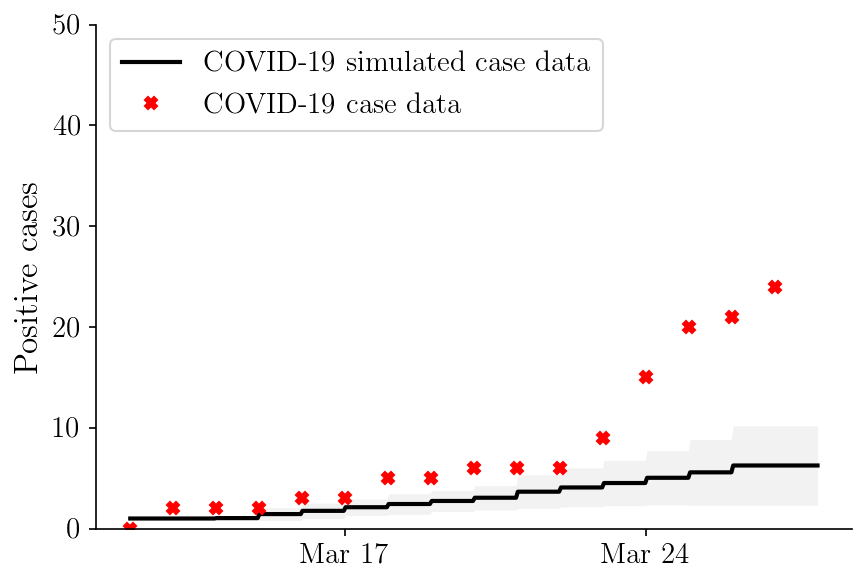

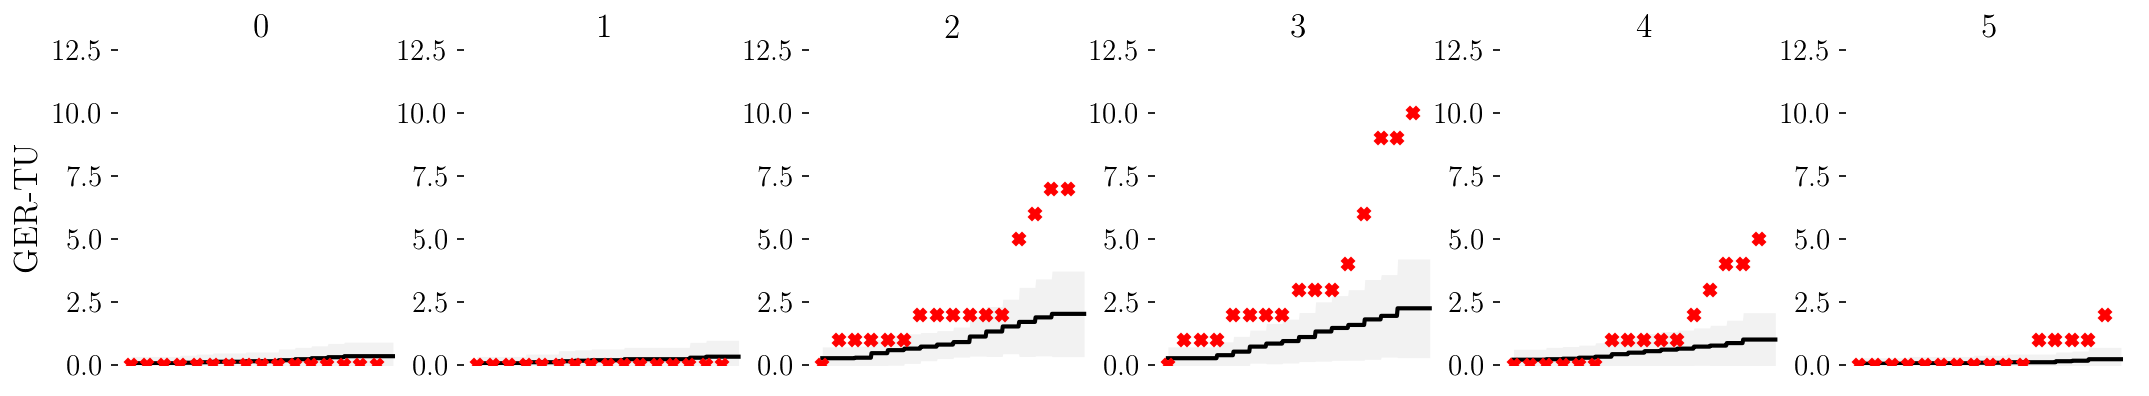

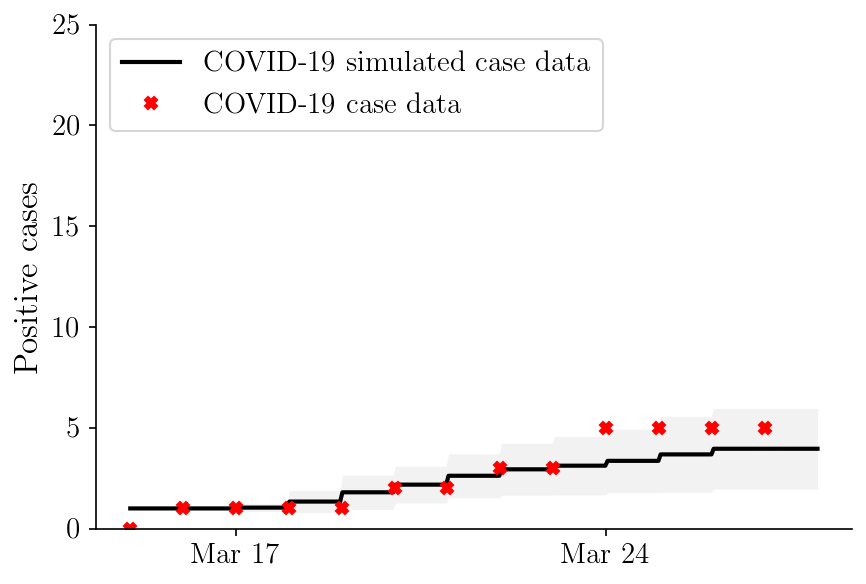

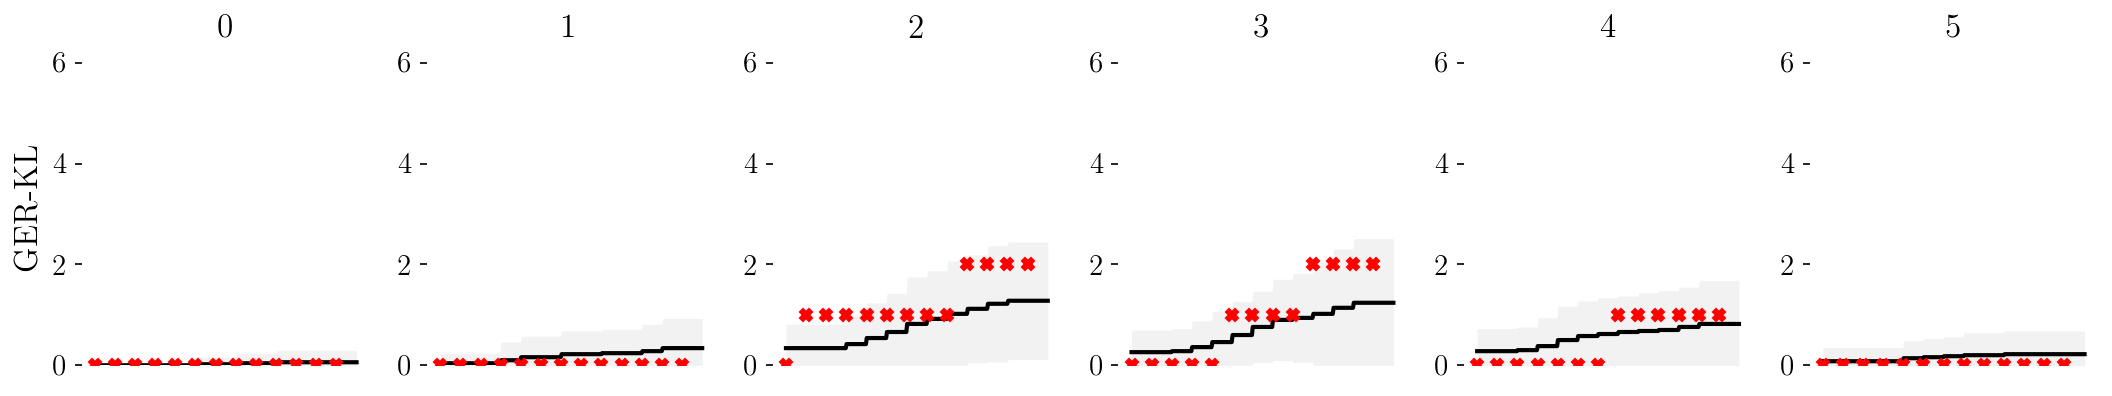

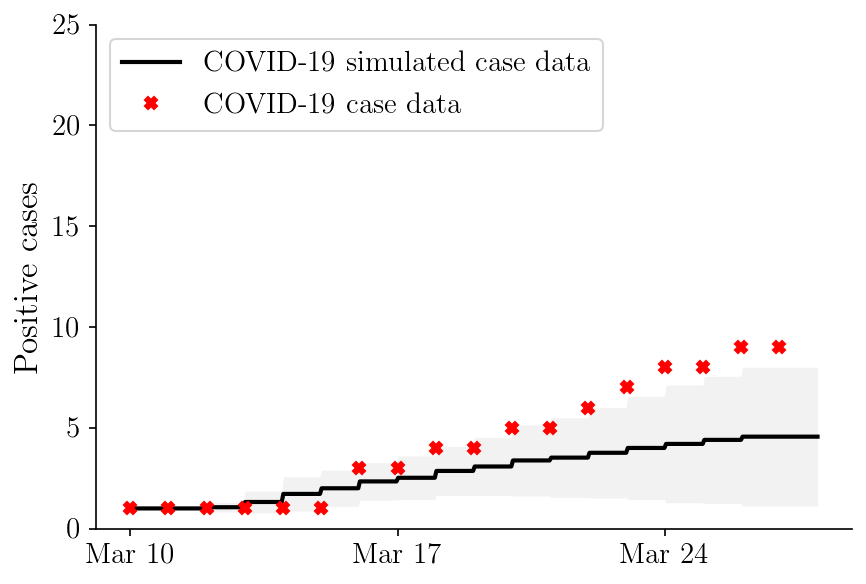

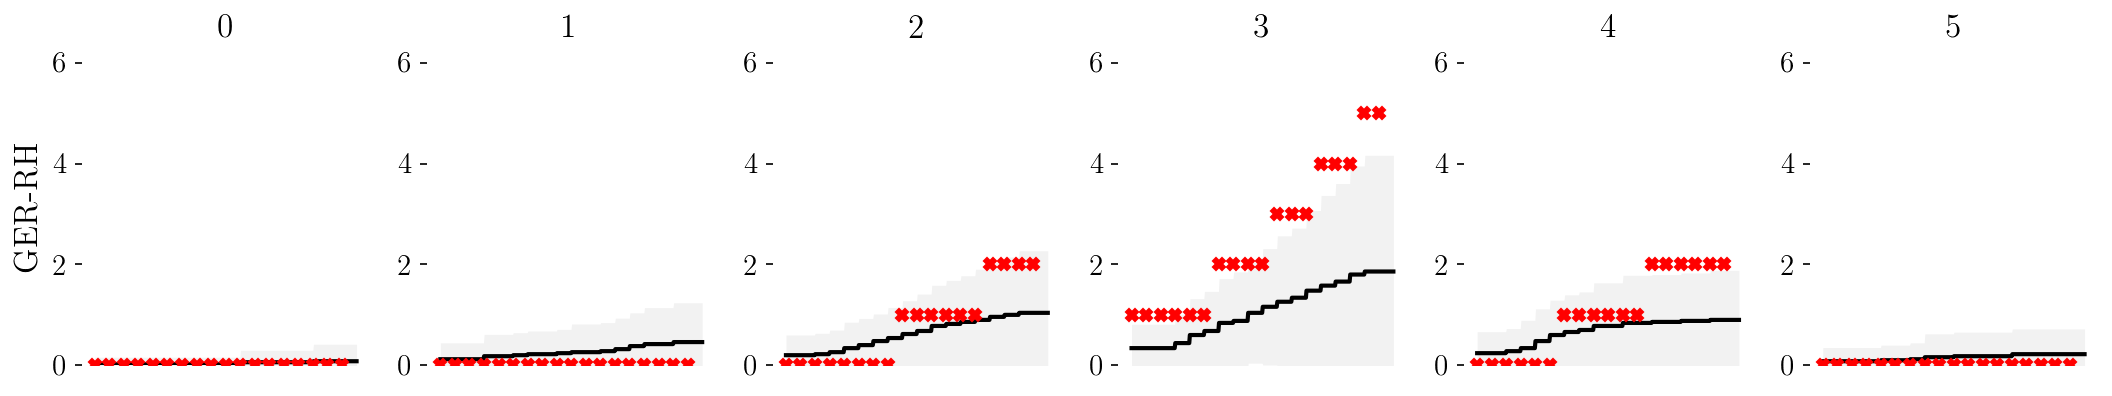

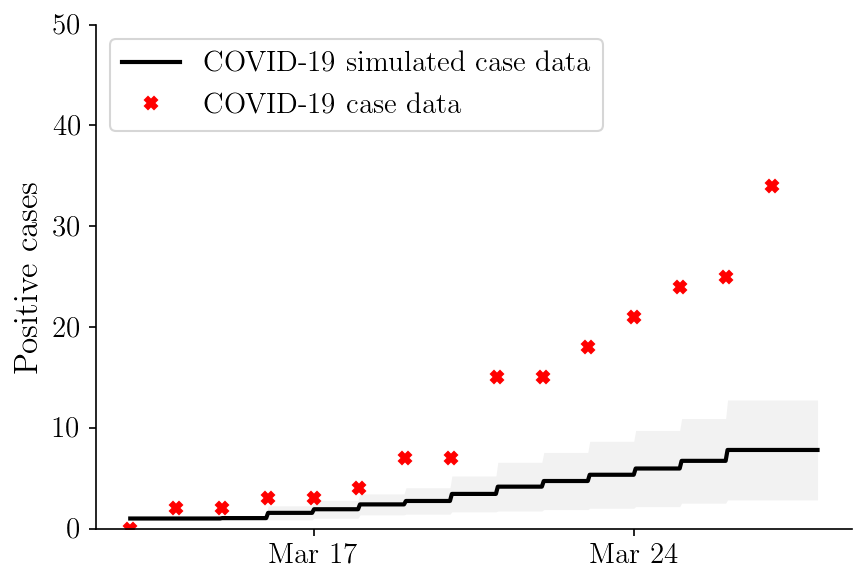

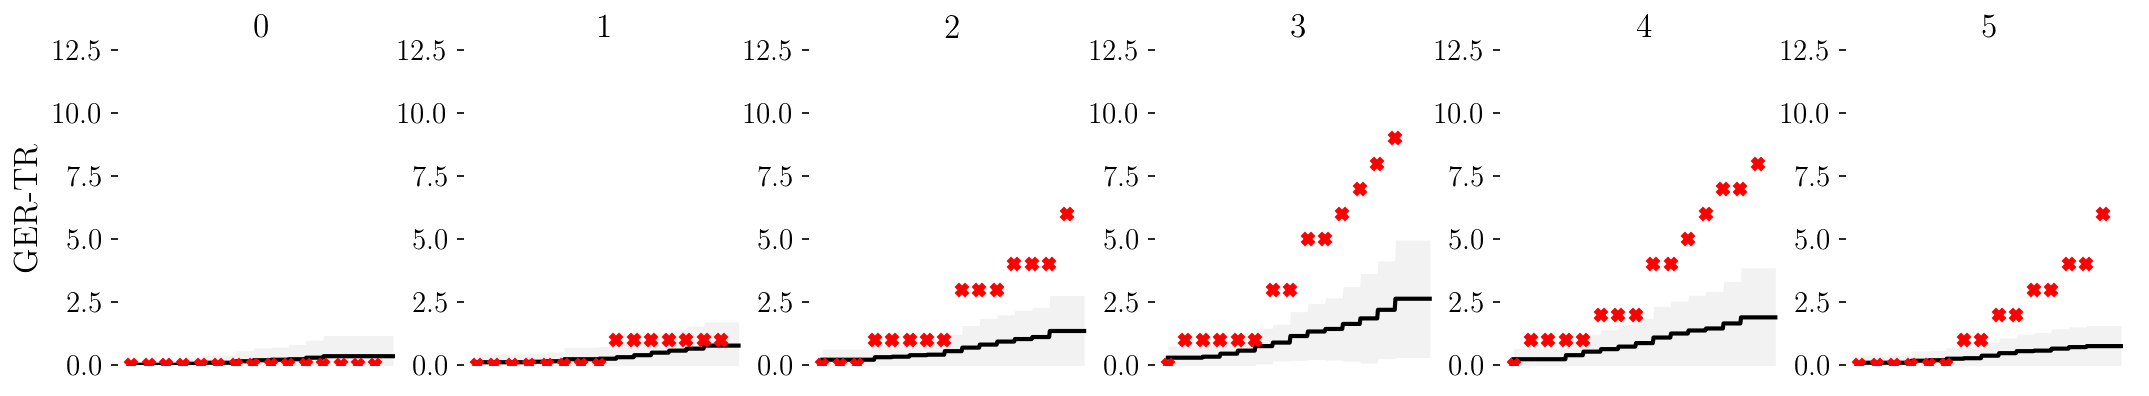

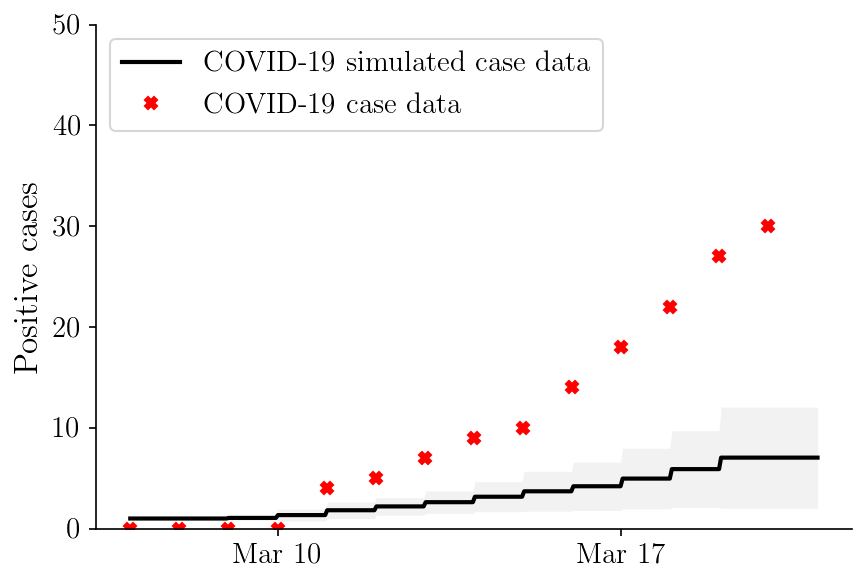

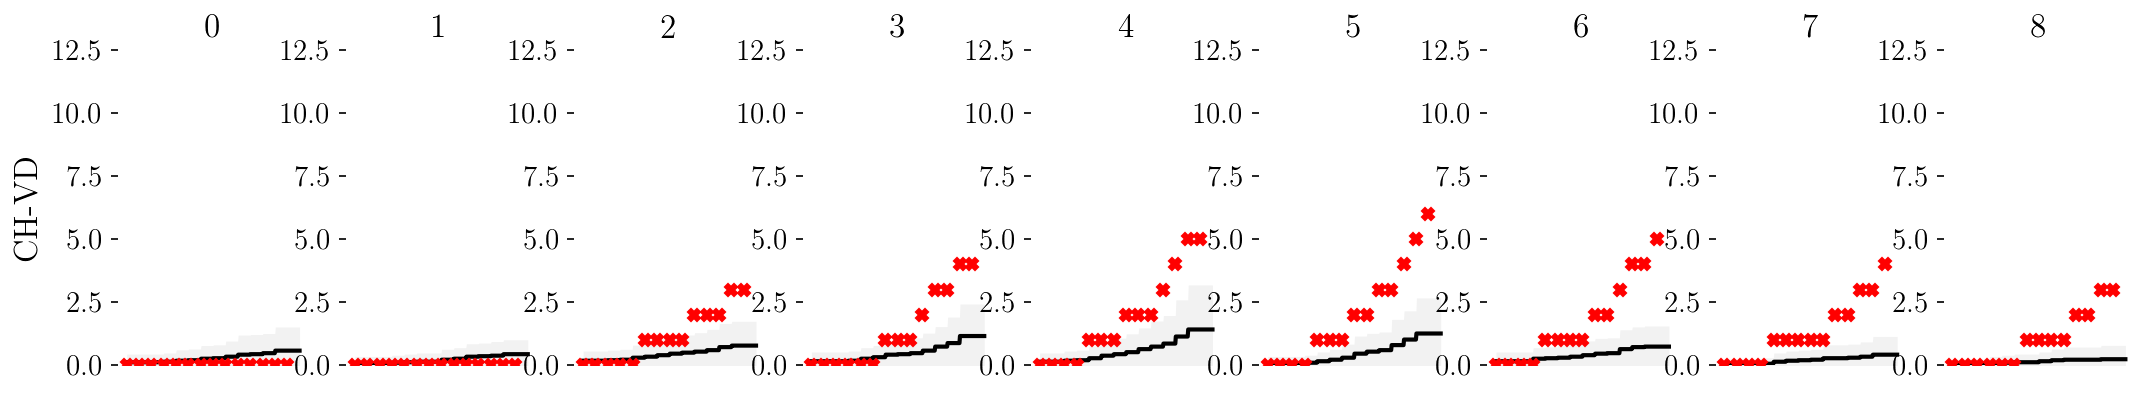

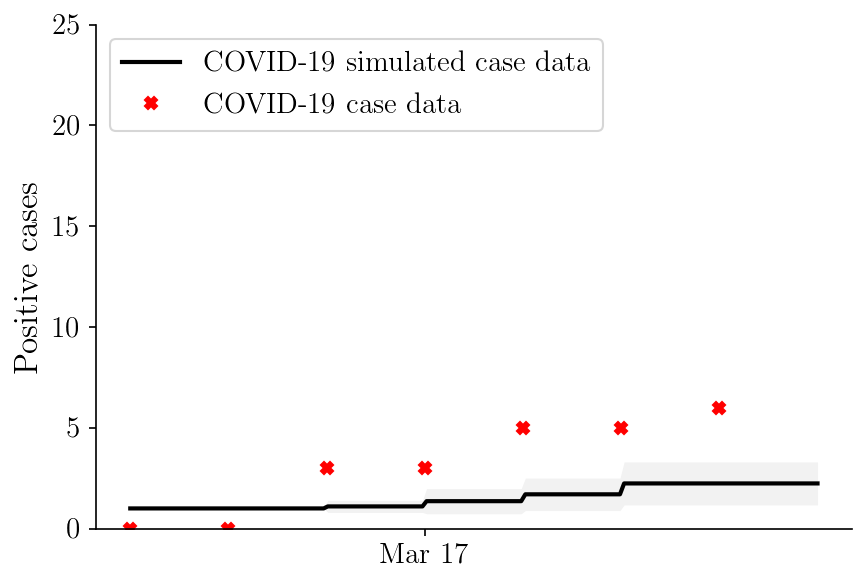

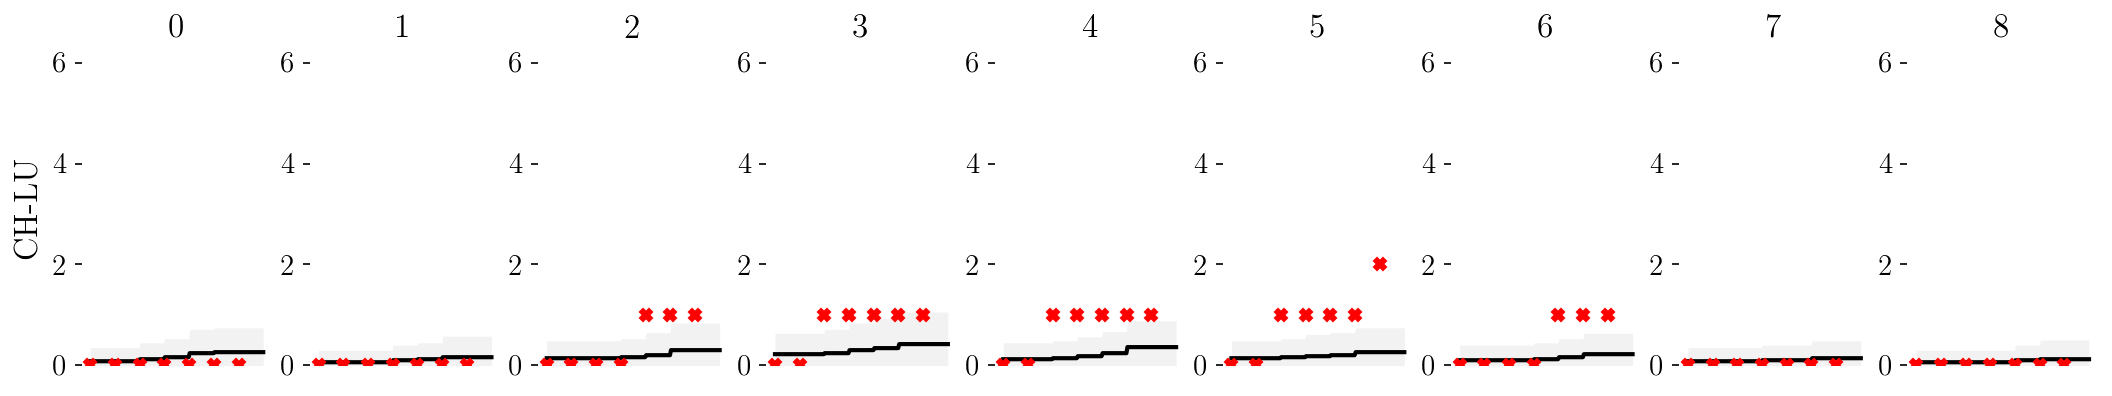

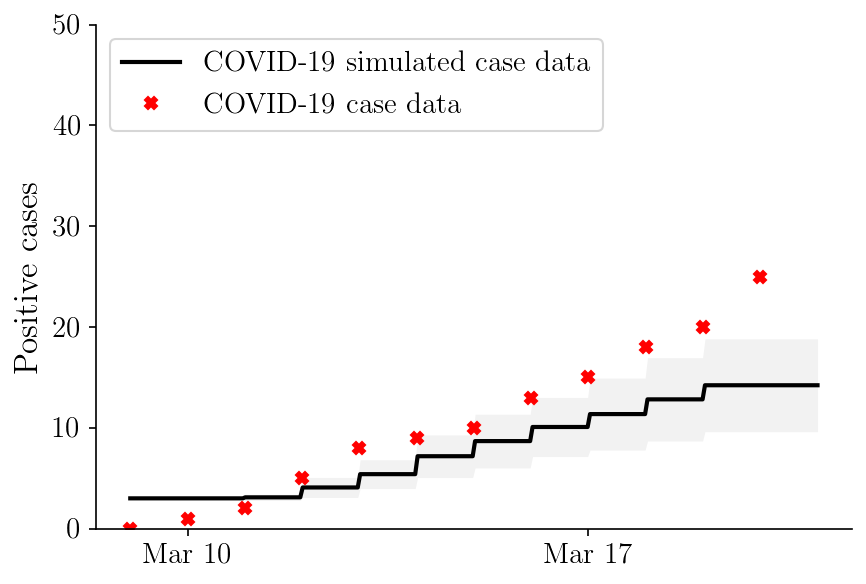

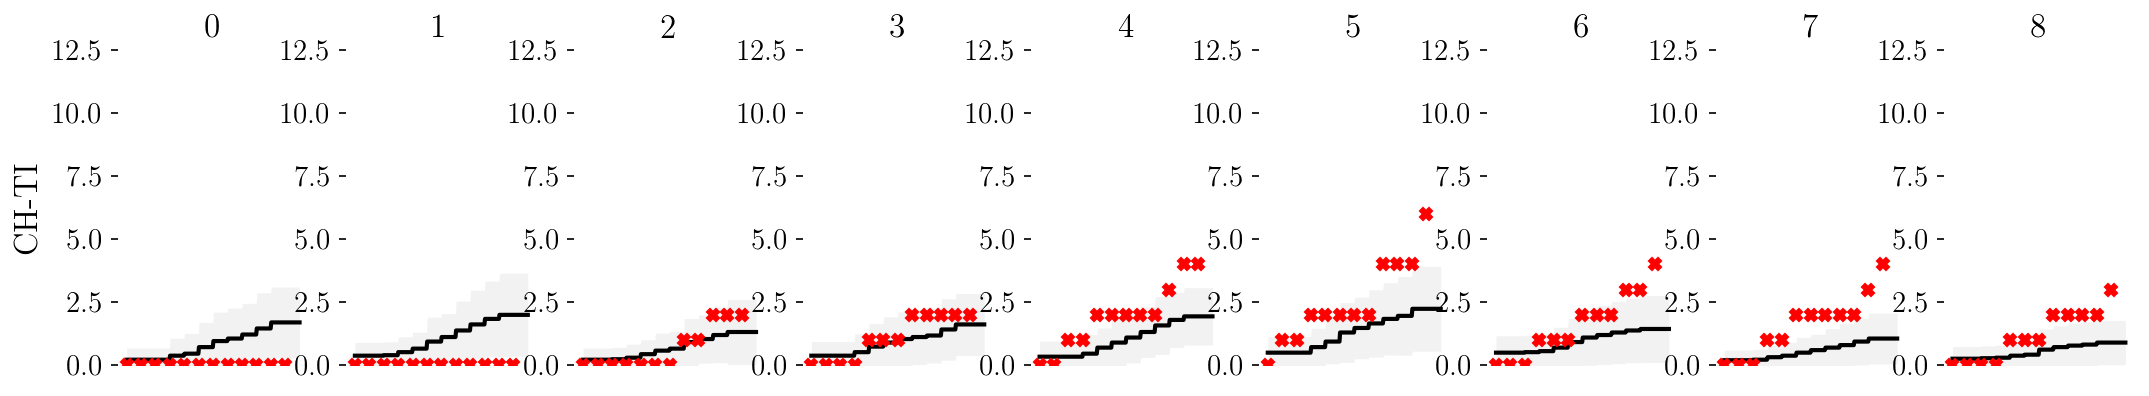

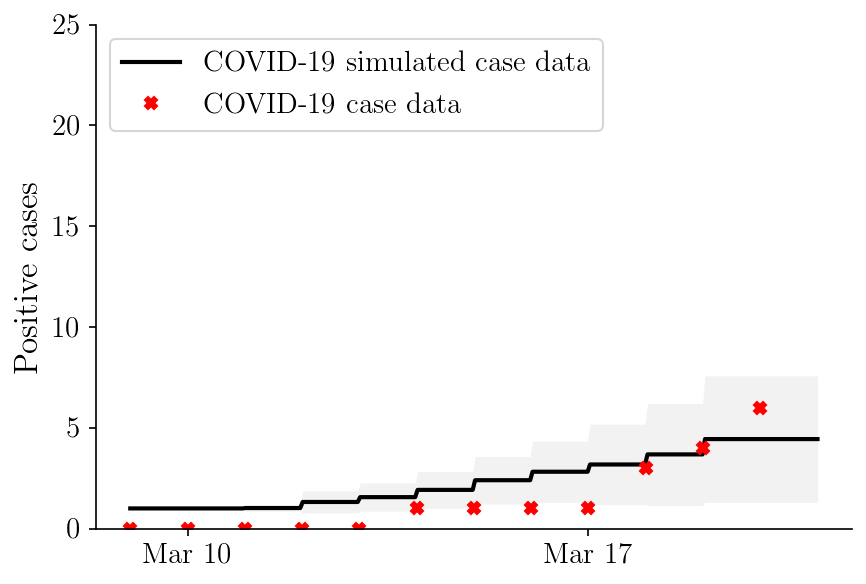

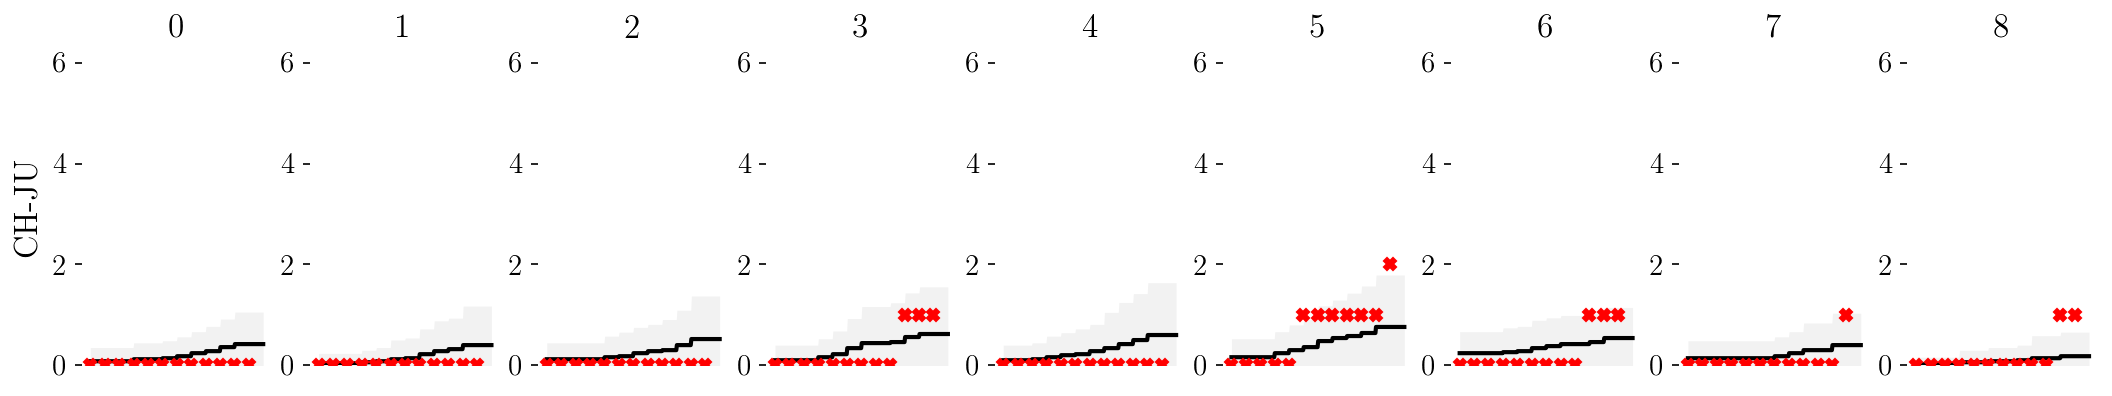

In [9]:
ymax = {
    'GER' : {
        'TU' : 50,
        'KL' : 20,
        'RH' : 20,
        'TR' : 50,
    },
    'CH' : {
        'VD' : 50,
        'LU' : 20,
        'TI' : 50,
        'JU' : 20,
    }
}

if plot:
    for country in ['GER', 'CH']:
        for area in setting_paths[country].keys():
            
#             try:
            
            if True:
                print(country, area)

                # start simulation when calibration started       
                mob_settings = setting_paths[country][area][0]
                start_date_calibration = setting_paths[country][area][1]
                end_date_calibration = setting_paths[country][area][2]

                # lockdown dates
                start_date_lockdown = settings_lockdown_dates[country]['start']
                end_date_lockdown = settings_lockdown_dates[country]['end']      

                # set time frame
                if calibration_period_only:
                    start_date = start_date_calibration
                    end_date = end_date_calibration
                else:
                    start_date = start_date_calibration
                    end_date = end_date_lockdown

                sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
                max_time = TO_HOURS * sim_days # in hours

                # load mobility file
                with open(mob_settings, 'rb') as fp:
                    obj = pickle.load(fp)
                mob = MobilitySimulator(**obj)

                # case data + scaling
                unscaled_area_cases = collect_data_from_df(country=country, area=area, datatype='new',
                    start_date_string=start_date, end_date_string=end_date)

                sim_cases, unscaled_sim_cases = downsample_cases(unscaled_area_cases, mob)

                appdx = 'full' if full_scale else 'downscaled'
                if calibration_period_only:
                    summary = load_summary('summary-calib--{}-{}--{}.pk'.format(country, area, appdx))
                else:
                    summary = load_summary('summary-calib_lockdown--{}-{}--{}-{}.pk'.format(
                        country, area, appdx, p_stay_home))


                plotter = Plotter()
                plotter.plot_positives_vs_target(
                    summary, sim_cases.sum(axis=1), 
                    title='Calibration period', 
                    filename='calibration--{}-{}'.format(country, area),
                    figsize=(6, 4),
                    start_date=start_date,
                    errorevery=1, acc=1000, 
                    ymax=ymax[country][area],
                )

                plotter.plot_age_group_positives_vs_target(
                    summary, sim_cases, 
                    ytitle=f'{country}-{area}',
                    filename='calibration--{}-{}-age'.format(country, area),
                    figsize=(16, 2.5),
                    start_date=start_date,
                    errorevery=1, acc=1000, 
                    ymax=ymax[country][area] / 4)

#             except:
#                 print(country, area, ' not found.')
        